In [1]:
# Basic libraries for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Tree-based models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost model
from xgboost import XGBClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [2]:
columns = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
    'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# Wilderness Area columns (binary)
wilderness_areas = [f'Wilderness_Area{i}' for i in range(1, 5)]

# Soil Type columns (binary)
soil_types = [f'Soil_Type{i}' for i in range(1, 41)]

# Target column
target = ['Cover_Type']

# Combine all column names
columns += wilderness_areas + soil_types + target

In [3]:
df = pd.read_csv('D:\Training Sets\Elevvo\Forest cover type classification\covtype.data', header=None, names=columns)
df.to_csv('D:\Training Sets\Elevvo\Forest cover type classification\covtype.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [4]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


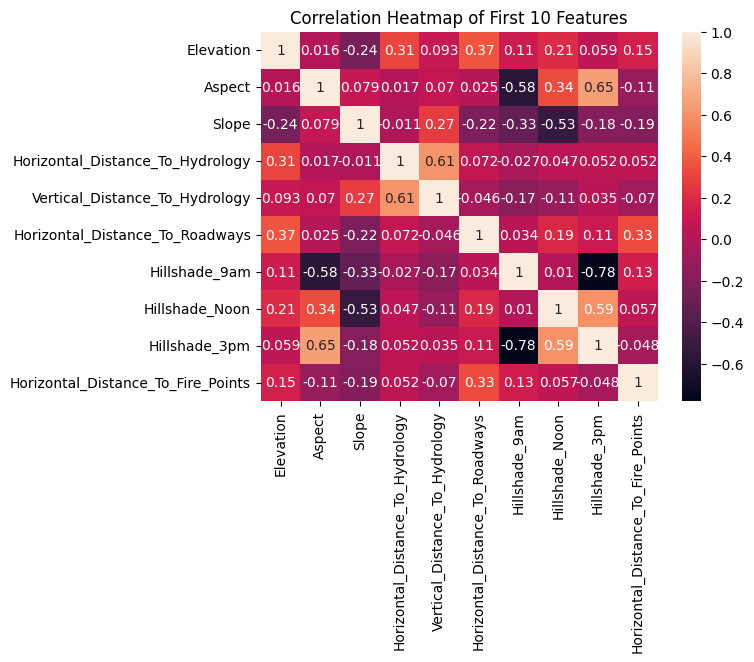

In [5]:
corr = df.iloc[:, :10].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap of First 10 Features")
plt.show()

In [6]:
soil_type_cols = [col for col in df.columns if col.startswith('Soil_Type')]
zero_90_cols = [col for col in soil_type_cols if (df[col] == 0).mean() >= 0.98]

print("Soil_Type columns with >=90% zeros:")
for col in zero_90_cols:
    print(col)

Soil_Type columns with >=90% zeros:
Soil_Type1
Soil_Type2
Soil_Type3
Soil_Type5
Soil_Type6
Soil_Type7
Soil_Type8
Soil_Type9
Soil_Type14
Soil_Type15
Soil_Type16
Soil_Type17
Soil_Type18
Soil_Type19
Soil_Type20
Soil_Type21
Soil_Type25
Soil_Type26
Soil_Type27
Soil_Type28
Soil_Type34
Soil_Type35
Soil_Type36
Soil_Type37
Soil_Type40


In [7]:
df.drop(columns=zero_90_cols, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [9]:
def find_outliers_columns(df):
    outliers_columns = []
    for column in df.select_dtypes(include=[np.number]):
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR
        if ((df[column] < lower_bound) | (df[column] > upper_bound)).any():
            outliers_columns.append(column)
    return outliers_columns



outliers_columns_list = find_outliers_columns(df)
print("Columns with outliers:", outliers_columns_list)

Columns with outliers: ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area2', 'Wilderness_Area4', 'Soil_Type4', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39', 'Cover_Type']


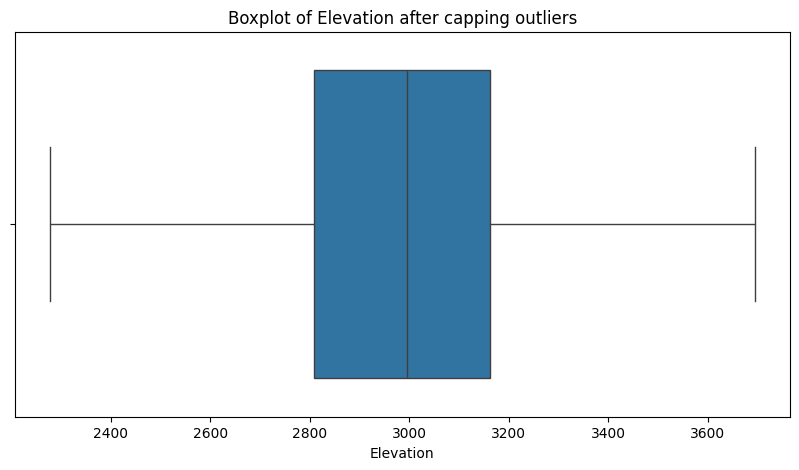

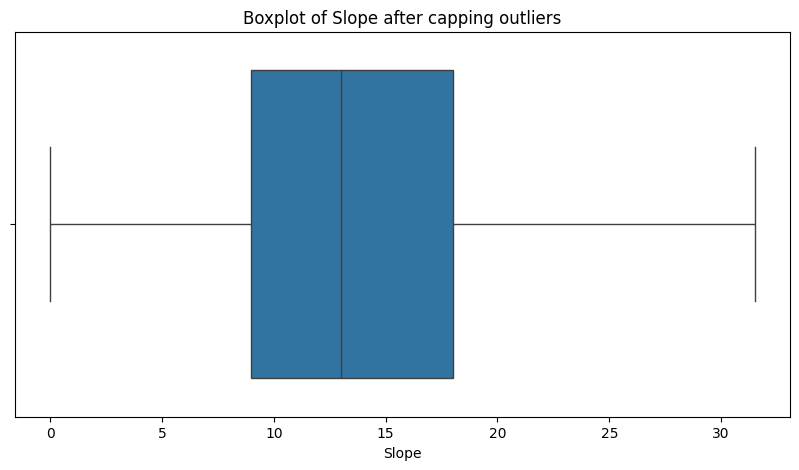

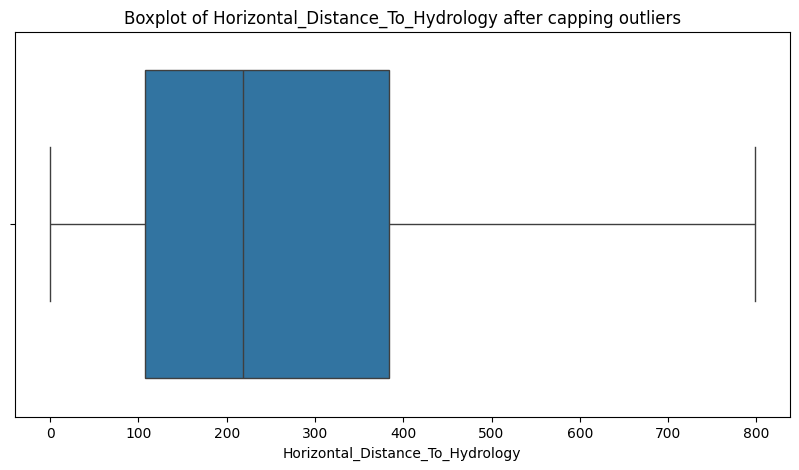

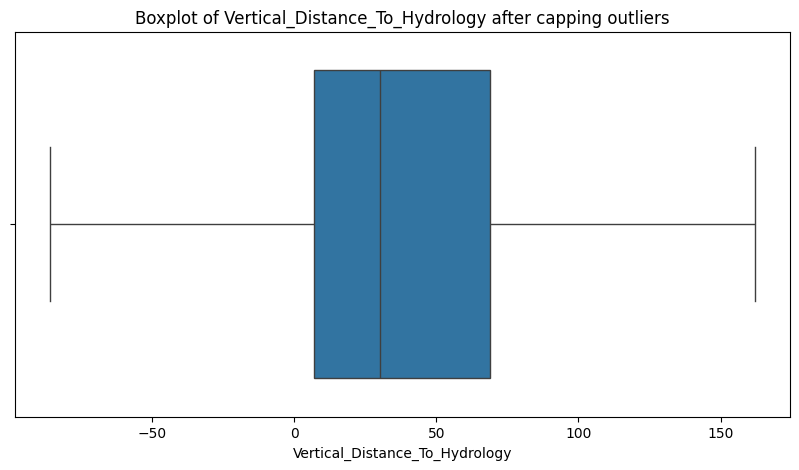

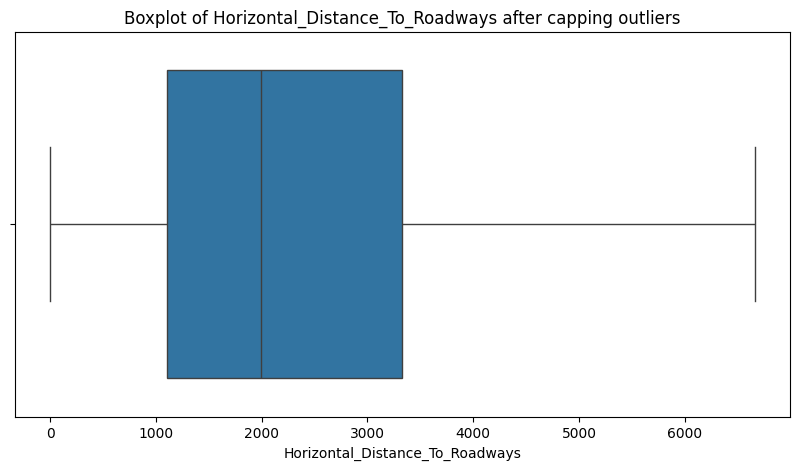

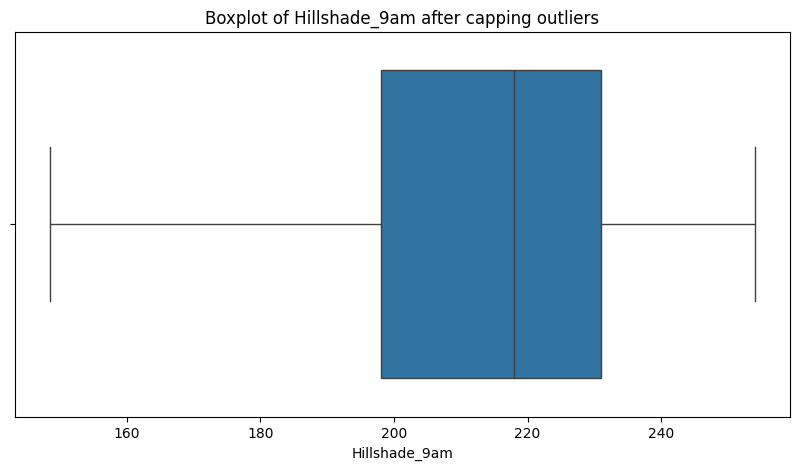

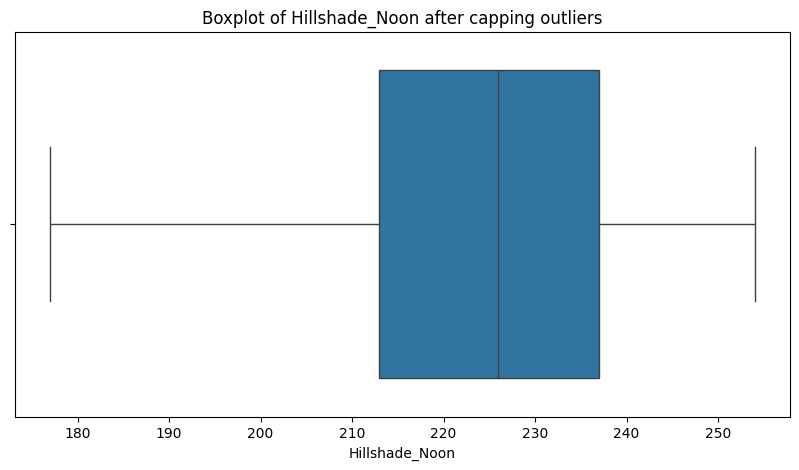

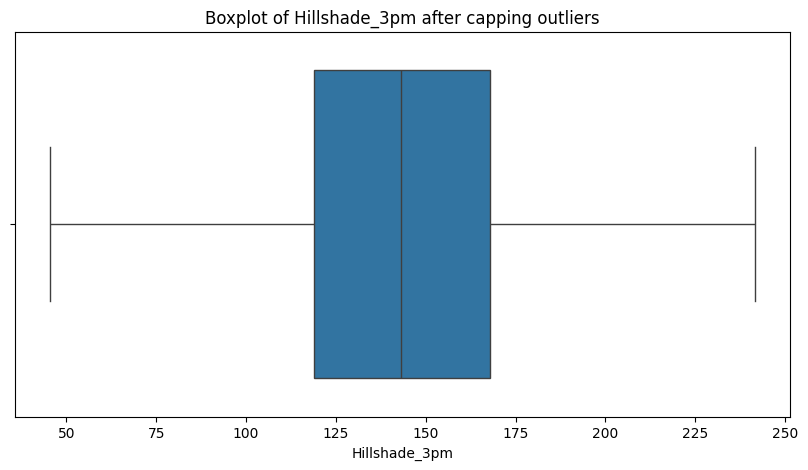

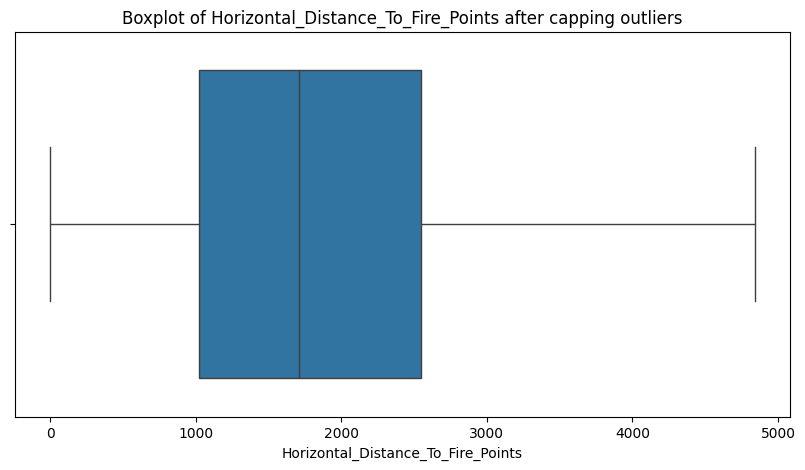

In [10]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df



columns_to_check = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


for col in columns_to_check:
 df = cap_outliers(df, col)

boxplot_columns = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
for column in boxplot_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column} after capping outliers')
    plt.show()

In [11]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Decision Tree Classifier Results:
              precision    recall  f1-score   support

           1       0.93      0.94      0.93     42368
           2       0.95      0.94      0.94     56661
           3       0.91      0.91      0.91      7151
           4       0.78      0.79      0.78       549
           5       0.82      0.82      0.82      1899
           6       0.86      0.85      0.85      3473
           7       0.94      0.94      0.94      4102

    accuracy                           0.93    116203
   macro avg       0.88      0.88      0.88    116203
weighted avg       0.93      0.93      0.93    116203

Accuracy: 0.9329879607239056


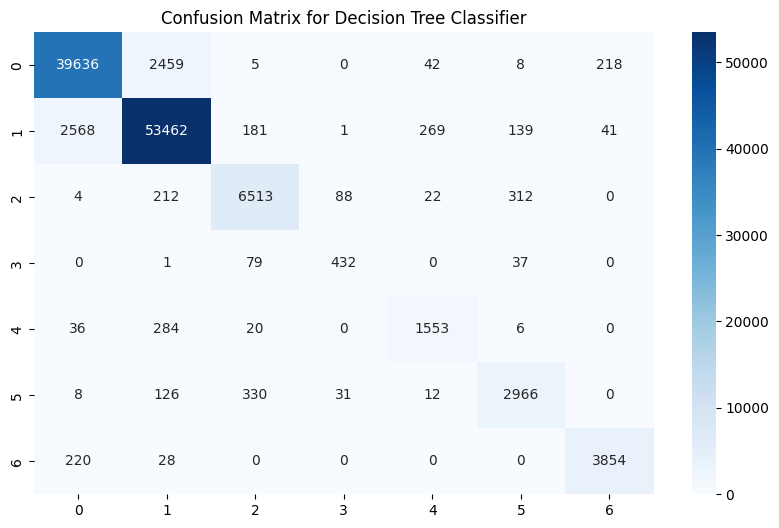

In [13]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)
print("Decision Tree Classifier Results:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Decision Tree Classifier")

Acc_DTC = accuracy_score(y_test, y_pred)
print("Accuracy:", Acc_DTC)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Acc_Rf=accuracy_score(y_test, y_pred_rf)
print("Accuracy:",Acc_Rf)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")


Accuracy: 0.7412459230828808

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     42368
           1       0.75      0.83      0.79     56661
           2       0.67      0.80      0.73      7151
           3       0.77      0.46      0.58       549
           4       0.83      0.10      0.17      1899
           5       0.53      0.11      0.18      3473
           6       0.82      0.51      0.63      4102

    accuracy                           0.74    116203
   macro avg       0.73      0.50      0.54    116203
weighted avg       0.74      0.74      0.73    116203



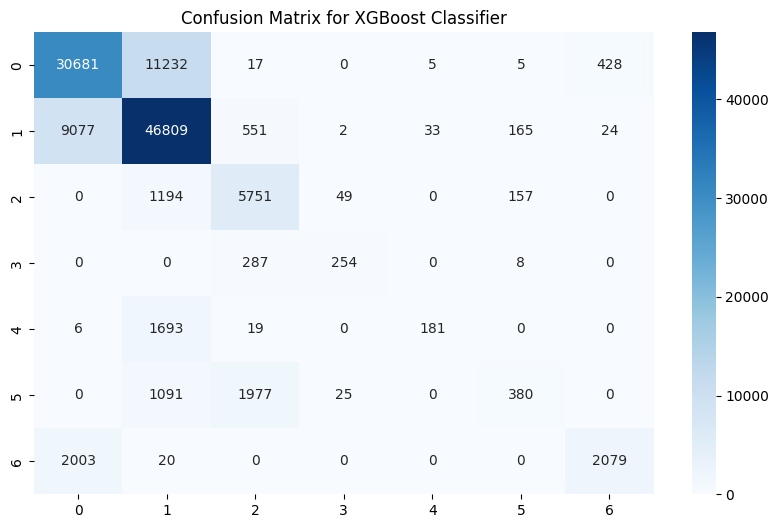

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

# -1 to adjust target for XGBoost
# XGBoost requires target labels to start from 0
y_train = y_train - 1  
y_test = y_test - 1    



xgb_model = XGBClassifier(
    n_estimators=100,   
    learning_rate=0.1,  
    max_depth=3,        
    random_state=42,
    eval_metric="mlogloss"  
)




xgb_model.fit(x_train, y_train)


y_pred_xgb = xgb_model.predict(x_test)


# Accuracy
acc_boosting= accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", acc_boosting)

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

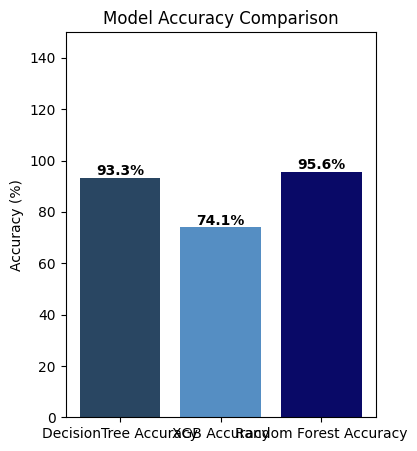

In [ ]:
accuracies = [Acc_DTC*100, acc_boosting*100, Acc_Rf*100]
labels = ['DecisionTree Accuracy','XGB Accuracy', 'Random Forest Accuracy']

plt.figure(figsize=(4,5))
plt.bar(labels, accuracies, color=["#294662","#558EC3", "#090967"])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 150)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()